In [1]:

from torch.utils.data import DataLoader
import torch.utils.data as torch_data
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim


from os.path import join
import os
import json
from datetime import datetime


from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display as ipython_display
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
!wget -O modelnet40-normal_numpy.tar.zip https://box.skoltech.ru/index.php/s/dXgCWvAcYjgd7FC/download
!unzip modelnet40-normal_numpy.tar.zip > /dev/null
!rm modelnet40-normal_numpy.tar.zip > /dev/nully
!tar -xvf modelnet40-normal_numpy.tar > /dev/null


--2024-01-23 20:28:08--  https://box.skoltech.ru/index.php/s/dXgCWvAcYjgd7FC/download
Resolving box.skoltech.ru (box.skoltech.ru)... 195.133.216.199
Connecting to box.skoltech.ru (box.skoltech.ru)|195.133.216.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1732629450 (1.6G) [application/zip]
Saving to: ‘modelnet40-normal_numpy.tar.zip’

modelnet40-normal_n 100%[===================>]   1.61G  15.8MB/s    in 1m 44s  

2024-01-23 20:29:54 (15.8 MB/s) - ‘modelnet40-normal_numpy.tar.zip’ saved [1732629450/1732629450]



In [3]:
# A data class for modelNet40 given every class iot numerical representation
# from 0 - 39
# pc - point cloud

class ModelNet(torch_data.Dataset):
    classes = {
        'airplane': 0, 'bathtub': 1, 'bed': 2, 'bench': 3,
        'bookshelf': 4, 'bottle': 5, 'bowl': 6, 'car': 7,
        'chair': 8, 'cone': 9, 'cup': 10, 'curtain': 11,
        'desk': 12, 'door': 13, 'dresser': 14, 'flower_pot': 15,
        'glass_box': 16, 'guitar': 17, 'keyboard': 18, 'lamp': 19,
        'laptop': 20, 'mantel': 21, 'monitor': 22, 'night_stand': 23,
        'person': 24, 'piano': 25, 'plant': 26, 'radio': 27,
        'range_hood': 28, 'sink': 29, 'sofa': 30, 'stairs': 31,
        'stool': 32, 'table':
        33, 'tent': 34, 'toilet': 35,
        'tv_stand': 36, 'vase': 37, 'wardrobe': 38, 'xbox': 39
    }

    def __init__(self, root, split, num_points=1024, transform=None):
        super().__init__()
        self.root = root
        self.n_points = num_points

        self.transform = transform

        if split == 'train':
            self.files = np.loadtxt(join(root, 'modelnet40_train.txt'), dtype=str)
        else:
            self.files = np.loadtxt(join(root, 'modelnet40_test.txt'), dtype=str)

        self.choice_idx = [np.random.choice(10000, self.n_points, replace=False) for _ in range(self.__len__())]

    def load_npy(self, f, idx):
        f = join(self.root, f)
        data = np.load(f)

        pc = data[:, :3]

        pc = pc[self.choice_idx[idx], :]

        if self.transform is not None:
            pc = self.transform(pc)

        return pc

    def __getitem__(self, idx):
        f = self.files[idx]
        cls = '_'.join(f.split('_')[:-1])

        f = '%s/%s.npy' % (cls, f)

        pc = self.load_npy(f, idx)

        return pc, self.classes[cls]

    def __len__(self):
        return len(self.files)

In [4]:

class RandomJitterTransform(object):
    def __init__(self, sigma=0.01, clip=0.05):
        self.sigma = sigma
        self.clip = clip

    def __call__(self, data):
        """ Randomly jitter points. jittering is per point.
            Input:
              Nx3 array, original point clouds
            Return:
              Nx3 array, jittered point clouds
        """
        N, C = data.shape
        assert (self.clip > 0)
        jittered_data = np.clip(self.sigma * np.random.randn(N, C), -1 * self.clip, self.clip)

        jittered_data += data

        return np.float32(jittered_data)




class RandomRotateTransform(object):
    def __init__(self):
        pass

    def __call__(self, data):
        """ Randomly rotate the point clouds to augument the dataset
            rotation is per shape based along ANY direction
            Input:
              Nx3 array, original point clouds
            Return:
              Nx3 array, rotated point clouds

        """

        # generate random angle in [0, 2pi]
        rotation_angle = np.random.uniform() * 2 * np.pi


        rotation_matrix_y = torch.tensor([[np.cos(rotation_angle), 0, np.sin(rotation_angle)],
                                          [0, 1, 0],
                                          [-np.sin(rotation_angle), 0, np.cos(rotation_angle)]])


        # Apply the rotations sequentially
        rotated_data = np.dot(data.reshape((-1, 3)), rotation_matrix_y)


        return np.float32(rotated_data)


class ScaleTransform(object):
    def __init__(self):
        pass

    def __call__(self, data):
        data = (data - data.min(  axis=0)) / (data.max(axis=0) - data.min(axis=0))
        return np.float32(data)

In [5]:
class TNet(nn.Module):
    def __init__(self, dim, num_points=1024):
        super().__init__()
        self.dim = dim
        self.conv1 = nn.Conv1d(dim, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(1024)


        self.fc1 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, dim*3)
        self.relu = nn.ReLU()



        self.max_pool = nn.MaxPool1d(kernel_size=num_points)


    def forward(self, x):
        bs = x.size()[0]


        x = x.transpose(2, 1)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = self.max_pool(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)



        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden



        return x




In [6]:

class PointNet(nn.Module):
    def __init__(self, num_classes=40, num_points=1024, use_dropout = True):
        super().__init__()
        self.tnet = TNet(3)
        self.use_dropout = use_dropout
        self.num_classes = num_classes

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.bn1 = torch.nn.BatchNorm1d(64)
        if self.use_dropout:
            self.dropout1d = nn.Dropout(p=0.1)


        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.bn2 = torch.nn.BatchNorm1d(128)
        if self.use_dropout:
            self.dropout2d = nn.Dropout(p=0.2)

        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn3 = torch.nn.BatchNorm1d(1024)
        if self.use_dropout:
            self.dropout3d = nn.Dropout(p=0.3)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)



        self.general_part = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, self.num_classes),
            #nn.Softmax()
        )

    def forward_backbone(self, x):
        trans = self.tnet(x)
        x = torch.bmm(x, trans)
        #print(f'in x in pointnet {x.shape}')
        bs = x.size()[0]
        x = x.transpose(2, 1)

        x = F.relu(self.bn1(self.conv1(x)))
        if self.use_dropout:
          x = self.dropout1d(x)

        x = F.relu(self.bn2(self.conv2(x)))
        if self.use_dropout:
          x = self.dropout2d(x)


        x = F.relu(self.bn3(self.conv3(x)))
        if self.use_dropout:
          x = self.dropout3d(x)

        # x, _ = torch.max(x, 2)

        #x = self.max_pool(x).view(bs, -1)

        x = self.max_pool(x)


        return x
    def forward_classifier(self, x):
      x = x.view(-1, 1024)


      x = self.general_part(x)




      return x


    def forward(self, x):
      x = self.forward_backbone(x)
      x = self.forward_classifier(x)
      return x









In [7]:
class VAE(nn.Module):
    def __init__(self, batch_size):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = self.build_encoder()
        self.batch_size = batch_size

        # Bottleneck layers
        self.conv_mu = nn.Conv1d(1024, 1024, kernel_size=1)
        self.conv_logvar = nn.Conv1d(1024, 1024, kernel_size=1)

        # Decoder layers
        self.decoder = self.build_decoder()

    def build_encoder(self):
        return nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )


    def build_decoder(self):
        return nn.Sequential(
            nn.ConvTranspose1d(1024, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 3, kernel_size=1),
            nn.BatchNorm1d(3),
            nn.Sigmoid()
        )


    def reparameterize(self, mu, logvar):

        std = torch.exp(0.5 * logvar)

        eps = torch.randn_like(std)
        return mu + eps * std.clamp(min=1e-5)

    def decode(self, x):
        batch_size = x.size(0)

        x = x.view(-1, 1024, 1)


        # Bottleneck layers
        mu = self.conv_mu(x)

        mu = mu.view(batch_size, -1)
        logvar = self.conv_logvar(x)
        logvar = logvar.view(batch_size, -1)
        z = self.reparameterize(mu, logvar)



        # Decoder
        z = z.view(batch_size, -1, 1).repeat(1,1, 1024)
        x = self.decoder(z)
        #x = x.view(32, 3, 1)

        x = x.transpose(2, 1)


        return x, mu, logvar


    def forward(self, x):
        batch_size = x.size(0)

        # Encoder
        x = x.transpose(2, 1)
        x = self.encoder(x)


        # Global max pooling for bottleneck layer
        x, _ = torch.max(x, 2)

        x = x.view(-1, 1024, 1)


        # Bottleneck layers
        mu = self.conv_mu(x)

        mu = mu.view(batch_size, -1)
        logvar = self.conv_logvar(x)
        logvar = logvar.view(batch_size, -1)
        z = self.reparameterize(mu, logvar)



        # Decoder
        z = z.view(batch_size, -1, 1).repeat(1,1, 1024)
        x = self.decoder(z)
        #x = x.view(32, 3, 1)

        x = x.transpose(2, 1)


        return x, mu, logvar


In [8]:
class HybridPointVAE(nn.Module):
    def __init__(self, num_classes=40, num_points=1024, use_dropout=True, batch_size=32):
        super(HybridPointVAE, self).__init__()

        self.point_net = PointNet(num_classes=num_classes, num_points=num_points, use_dropout=use_dropout)
        self.vae = VAE(batch_size=batch_size)


    def forward(self, x):
        z = self.point_net.forward_backbone(x)


        vae_output, mu, logvar = self.vae.decode(z)
        #


        pointnet_output = self.point_net.forward_classifier(z)
        #print(f'h_point{pointnet_output.shape}')

        return pointnet_output,vae_output, mu, logvar


In [9]:

def loss_func_vae(output, target, mu, logvar):



    # # Compute MSE loss

    bce_loss = F.mse_loss(output, target)
    #bce_loss = F.binary_cross_entropy(output, target)


    # KL Divergence term (
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    total_loss = bce_loss + kl_divergence

    return total_loss



In [10]:
# Configuration
config = {
    "lr": 1e-4,
    "gamma": 1,
    "batch_size": 32,
    "model": {
        "conv1a_out": 64,
        "conv2a_out": 128,
        "conv3a_out": 256,
        "conv4a_out": 512,
        "conv5a_out": 1024
    },
}
def get_model_net_40(datadir, batch_size, num_points):
    transform = transforms.Compose([
        RandomRotateTransform(),
        RandomJitterTransform(),
        ScaleTransform(),
    ])

    train_data = ModelNet(datadir, split='train', num_points=num_points, transform=transform)
    test_data = ModelNet(datadir, split='test', num_points=num_points, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader




In [11]:
train_loader, test_loader = get_model_net_40('./modelnet40-normal_numpy/', batch_size=config['batch_size'], num_points=1024)

len(train_loader), len(test_loader)

(308, 78)

In [12]:

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory for saving logs and checkpoints
run_name = datetime.today().strftime('%Y-%m-%d')
run_dir = os.path.join(os.getcwd(), '/content', run_name)
os.makedirs(run_dir, exist_ok=True)


# Instantiate the hybrid model
model = HybridPointVAE(num_classes=40, num_points=1024, use_dropout=True, batch_size=config['batch_size'])

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
loss_func_cls = nn.CrossEntropyLoss()

# Training loop
num_epochs = 50
training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total_loss = 0.0
    total = 0


    # Use tqdm for a progress bar
    for data in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = data

         # Move the inputs to the same device as the model
        inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)



        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        cls_outputs,vae_outputs,mu, logvar = model(inputs)

        vae_loss = loss_func_vae(vae_outputs, inputs, mu, logvar)


        cls_loss = loss_func_cls(cls_outputs, labels)



        # Total loss is the sum of classification and VAE loss
        #total_loss = cls_loss + vae_loss
        total_loss =  cls_loss


        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()


        _, predicted = torch.max(cls_outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    #print(f"Epoch {epoch + 1}/{num_epochs}")

    training_loss = running_loss / len(train_loader)
    #print(training_loss)
    training_accuracy = 100 * correct / total

    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

# Save the trained model
#torch.save(model.state_dict(), 'trained_hybrid_model.pth')





    # Inside the evaluation loop
    with torch.no_grad():
        total_test_loss = 0.0
        correct = 0.0
        total = 0.0
        # Initialize total test loss to zero

        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)  # Convert labels to torch.long


            cls_outputs,vae_outputs,mu, logvar = model(inputs)

            vae_loss = loss_func_vae(vae_outputs, inputs, mu, logvar)


            cls_loss = loss_func_cls(cls_outputs, labels)

            total_loss = cls_loss
            # Accumulate the test loss
            total_test_loss += total_loss.item()


            _, predicted = torch.max(cls_outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        test_accuracy = 100 * correct / total

        test_accuracies.append(test_accuracy)




        # Calculate the average test loss over all batches
        average_test_loss =  total_test_loss / len(test_loader)


        # Append the average test loss to the list
        test_losses.append(average_test_loss)


# Save all training and test metrics in the same folder
np.savetxt(os.path.join(run_dir, 'training_losses.txt'), np.array(training_losses))
np.savetxt(os.path.join(run_dir, 'training_accuracies.txt'), np.array(training_accuracies))
np.savetxt(os.path.join(run_dir, 'test_accuracies.txt'), np.array(test_accuracies))
np.savetxt(os.path.join(run_dir, 'test_losses.txt'), np.array(test_losses))

print("Training complete.")


Epoch 1/50:   0%|          | 0/308 [00:00<?, ?it/s]<ipython-input-12-c5ef54440782>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)
Epoch 1/50: 100%|██████████| 308/308 [00:26<00:00, 11.43it/s]
<ipython-input-12-c5ef54440782>:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)  # Convert labels to torch.long
Epoch 50/50: 100%|██████████| 308/308 [00:25<00:00, 12.21it/s]


Training complete.


In [20]:

def plot_and_save_metrics(run_dir):
    # Load training and test losses and accuracies from text files
    training_losses = np.loadtxt(os.path.join(run_dir, 'training_losses.txt'))
    test_losses = np.loadtxt(os.path.join(run_dir, 'test_losses.txt'))
    training_accuracies = np.loadtxt(os.path.join(run_dir, 'training_accuracies.txt'))
    test_accuracies = np.loadtxt(os.path.join(run_dir, 'test_accuracies.txt'))

    # Plot and save the combined losses
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss', color='#a83655')
    plt.plot(test_losses, label='Test Loss', color='#550f6d')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    losses_plot_path = os.path.join(run_dir, 'combined_losses_plot.png')
    plt.savefig(losses_plot_path)
    plt.grid(True)
    plt.show()
    plt.close()


    # Plot and save the combined accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(training_accuracies, label='Training Accuracy', color='#a83655')
    plt.plot(test_accuracies, label='Test Accuracy', color='#550f6d')


    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    accuracies_plot_path = os.path.join(run_dir, 'accuracies_plot.png')
    plt.savefig(accuracies_plot_path)

    plt.grid(True)
    plt.show()
    plt.close()

    return losses_plot_path, accuracies_plot_path


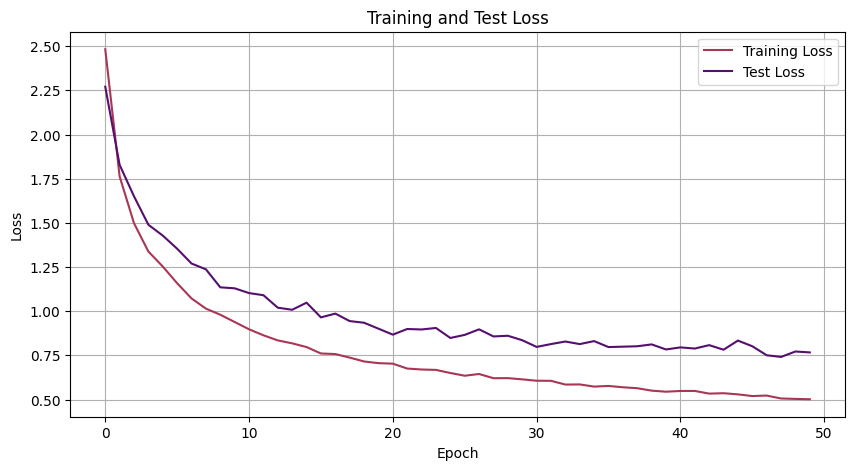

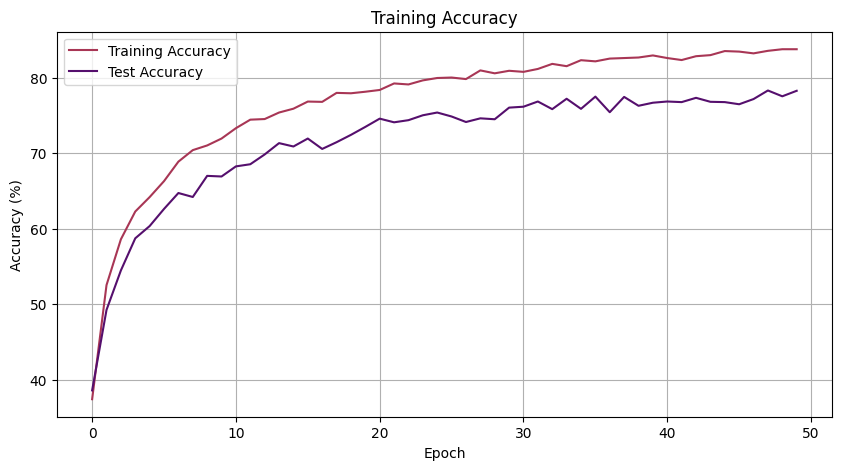

('/content/2024-01-23/combined_losses_plot.png',
 '/content/2024-01-23/accuracies_plot.png')

In [21]:
plot_and_save_metrics('/content/2024-01-23')